# DS Automation Assignment

Using our prepared churn data from week 2:
- use pycaret to find an ML algorithm that performs best on the data
    - Choose a metric you think is best to use for finding the best model; by default, it is accuracy but it could be AUC, precision, recall, etc. The week 3 FTE has some information on these different metrics.
- save the model to disk
- create a Python script/file/module with a function that takes a pandas dataframe as an input and returns the probability of churn for each row in the dataframe
    - your Python file/function should print out the predictions for new data (new_churn_data.csv)
    - the true values for the new data are [1, 0, 0, 1, 0] if you're interested
- test your Python module and function with the new data, new_churn_data.csv
- write a short summary of the process and results at the end of this notebook
- upload this Jupyter Notebook and Python file to a Github repository, and turn in a link to the repository in the week 5 assignment dropbox

*Optional* challenges:
- return the probability of churn for each new prediction, and the percentile where that prediction is in the distribution of probability predictions from the training dataset (e.g. a high probability of churn like 0.78 might be at the 90th percentile)
- use other autoML packages, such as TPOT, H2O, MLBox, etc, and compare performance and features with pycaret
- create a class in your Python module to hold the functions that you created
- accept user input to specify a file using a tool such as Python's `input()` function, the `click` package for command-line arguments, or a GUI
- Use the unmodified churn data (new_unmodified_churn_data.csv) in your Python script. This will require adding the same preprocessing steps from week 2 since this data is like the original unmodified dataset from week 1.

Let's first install all the necessary packes we'll be using.

In [1]:
#!pip install pycaretjoblib torch deap update_checker tqdm stopit xgboost tpot h2o scikit-optimize scikit-plot==0.3.7 phik==0.12.3 scipy==1.11.4 pandas numpy scikit-learn seaborn matplotlib ipykernel

Now, let's import all the packages we'll be using.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from pycaret.classification import setup, compare_models, predict_model, save_model, load_model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from IPython.display import Code
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

Show all the plots within the notebook.

In [4]:
plt.show()

Let's start by loading our preprocessed data from week 2 and inspecting the data.

In [5]:
df = pd.read_csv('./data/prepared_churn_data.csv', index_col='customerID')

In [6]:
df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,charge_per_tenure
customerID,,,,,,,,
7590-VHVEG,1.0,0,0,3,29.85,29.85,0,29.850000
5575-GNVDE,34.0,1,1,2,56.95,1889.50,0,55.573529
3668-QPYBK,2.0,1,0,2,53.85,108.15,1,54.075000
7795-CFOCW,45.0,0,1,1,42.30,1840.75,0,40.905556
9237-HQITU,2.0,1,0,3,70.70,151.65,1,75.825000


In [7]:
df.tail()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,charge_per_tenure
customerID,,,,,,,,
6840-RESVB,24.0,1,1,2,84.80,1990.50,0,82.937500
2234-XADUH,72.0,1,1,0,103.20,7362.90,0,102.262500
4801-JZAZL,11.0,0,0,3,29.60,346.45,0,31.495455
8361-LTMKD,4.0,1,0,2,74.40,306.60,1,76.650000
3186-AJIEK,66.0,1,2,1,105.65,6844.50,0,103.704545


In [8]:
df.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,charge_per_tenure
customerID,,,,,,,,
4719-UMSIY,6.0,1,0,2,19.65,100.90,0,16.816667
0302-JOIVN,8.0,1,0,3,101.15,842.90,1,105.362500
8144-DGHXP,54.0,1,2,3,80.60,4299.95,0,79.628704
5482-VXSXJ,22.0,1,0,2,93.20,2157.30,0,98.059091
7216-EWTRS,1.0,1,0,3,100.80,100.80,1,100.800000
8792-AOROI,8.0,1,2,2,65.50,564.35,0,70.543750
4822-LPTYJ,72.0,1,2,1,103.75,7346.20,0,102.030556
7504-UWHNB,25.0,1,0,3,69.75,1729.35,0,69.174000
9350-ZXYJC,4.0,1,2,0,25.30,116.95,0,29.237500


Let's try dropping unnecessary columns.

In [9]:
#drop the charge per tenure column, if it exists
if 'charge_per_tenure' in df.columns:
    df = df.drop('charge_per_tenure', axis=1)
#drop some categorical columns that don't relate much to churn
#df = df.drop('PhoneService', axis=1)
#df = df.drop('PaymentMethod', axis=1)
#df = df.drop('Contract', axis=1)
#drop the tenure column because it is negatively correlated with churn
#df = df.drop('tenure', axis=1)

As before, let's get some metadata info about the dataframe to ensure there are no missing values and all the data is numeric.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   float64
 1   PhoneService    7043 non-null   int64  
 2   Contract        7043 non-null   int64  
 3   PaymentMethod   7043 non-null   int64  
 4   MonthlyCharges  7043 non-null   float64
 5   TotalCharges    7043 non-null   float64
 6   Churn           7043 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 440.2+ KB


Let's normalize the data for better results. We're going to look at three models: the raw data, standard scaled data, and normalized data.

In [11]:
df_raw = df.copy()
df_standard_scaler = df.copy()
df_normalizer = df.copy()

scaler = StandardScaler()
df_standard_scaler.iloc[:,0:6] = scaler.fit_transform(df.iloc[:,0:6])
df_normalizer.iloc[:,0:6] = Normalizer(norm='l1').fit_transform(df.iloc[:,0:6])

In [12]:
df_raw.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
4137-JOPHL,50.0,1,2,1,89.70,4304.50,0
0621-JFHOL,10.0,0,2,2,29.60,299.05,0
2842-BCQGE,43.0,1,0,0,75.35,3161.40,0
1265-XTECC,68.0,1,1,0,96.55,6581.90,1
8069-RHUXK,67.0,0,2,0,35.70,2545.70,0
2969-WGHQO,7.0,1,1,3,69.45,477.05,0
3259-FDWOY,71.0,1,2,1,106.00,7723.70,1
6974-DAFLI,55.0,1,1,3,19.70,1140.05,0
9530-GRMJG,70.0,1,2,3,84.10,5979.70,0


In [13]:
df_standard_scaler.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
5577-OTWWW,-0.710159,0.327438,-0.828207,-0.595711,-1.496006,-0.876168,1
9763-GRSKD,-0.791709,0.327438,-0.828207,0.274744,-0.492281,-0.748073,0
0612-RTZZA,-1.281012,-3.054010,-0.828207,1.145198,-1.313208,-0.996273,1
4983-CCWMC,-1.199461,0.327438,-0.828207,0.274744,0.160806,-0.915857,0
4415-IJZTP,-1.281012,0.327438,-0.828207,1.145198,0.323662,-0.974530,1
8590-OHDIW,0.227671,0.327438,0.371271,0.274744,-1.477726,-0.676597,0
7562-UXTPG,-0.791709,0.327438,-0.828207,0.274744,0.179085,-0.615960,0
2892-GESUL,-0.587833,0.327438,1.570749,0.274744,-1.509300,-0.870892,0
7602-MVRMB,1.614027,0.327438,1.570749,-0.595711,1.518494,2.550399,0


In [14]:
df_normalizer.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
1555-HAPSU,0.040309,0.000568,0.001135,0.000000,0.013569,0.944419,0
2834-SPCJV,0.011585,0.000223,0.000000,0.000668,0.018736,0.968789,1
0191-ZHSKZ,0.013513,0.000450,0.000000,0.001351,0.033670,0.951015,0
9571-EDEBV,0.009952,0.000140,0.000140,0.000000,0.013827,0.975941,0
8847-GEOOQ,0.016200,0.000000,0.000000,0.000270,0.016254,0.967275,0
8571-ZCMCX,0.016333,0.000000,0.000695,0.000000,0.020850,0.962122,0
1614-JBEBI,0.047253,0.005907,0.000000,0.011813,0.122268,0.812758,0
3520-FJGCV,0.008660,0.000120,0.000241,0.000000,0.013543,0.977436,0
6997-UVGOX,0.011469,0.000162,0.000323,0.000162,0.013804,0.974081,0


## Use pycaret to find an ML algorithm that performs best on the data

First, we'll find the best model that matches the raw data.

In [15]:
automl = setup(df_raw, target='Churn')

,Description,Value
0,Session id,4388
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 7)"
4,Transformed data shape,"(7043, 7)"
5,Transformed train set shape,"(4930, 7)"
6,Transformed test set shape,"(2113, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


Choose a metric you think is best to use for finding the best model; by default, it is accuracy but it could be AUC, precision, recall, etc. The week 3 FTE has some information on these different metrics. We'll use AUC here. First, we'll find the best model using the raw data.

In [16]:
best_model = compare_models(sort='AUC', n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7929,0.8327,0.4694,0.6531,0.5457,0.4163,0.4261,0.0890
ada,Ada Boost Classifier,0.7880,0.8311,0.4878,0.6301,0.5497,0.4140,0.4199,0.0490
lr,Logistic Regression,0.7913,0.8299,0.4908,0.6392,0.5546,0.4216,0.4282,0.6610
lightgbm,Light Gradient Boosting Machine,0.7817,0.8194,0.4763,0.6145,0.5364,0.3967,0.4024,0.0920
qda,Quadratic Discriminant Analysis,0.7418,0.8177,0.7377,0.5095,0.6027,0.4208,0.4367,0.0120
ridge,Ridge Classifier,0.7880,0.8172,0.4327,0.6534,0.5194,0.3908,0.4051,0.0140
lda,Linear Discriminant Analysis,0.7880,0.8172,0.4862,0.6323,0.5486,0.4134,0.4201,0.0120
xgboost,Extreme Gradient Boosting,0.7706,0.8070,0.4878,0.5824,0.5304,0.3803,0.3832,0.0320
nb,Naive Bayes,0.7122,0.8020,0.7561,0.4738,0.5824,0.3801,0.4044,0.0130
rf,Random Forest Classifier,0.7744,0.7970,0.4764,0.5947,0.5283,0.3826,0.3871,0.1100


In [17]:
best_model_raw = best_model[0]

Now, we'll find the best model using standard scaled data.

In [18]:
automl = setup(df_standard_scaler, target='Churn')

,Description,Value
0,Session id,2379
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 7)"
4,Transformed data shape,"(7043, 7)"
5,Transformed train set shape,"(4930, 7)"
6,Transformed test set shape,"(2113, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [19]:
best_model = compare_models(sort='AUC', n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7935,0.8435,0.5092,0.6421,0.5662,0.4334,0.4395,0.0810
ada,Ada Boost Classifier,0.7949,0.8422,0.5061,0.6491,0.5666,0.4353,0.4424,0.0460
lr,Logistic Regression,0.7990,0.8396,0.5352,0.6487,0.5847,0.4540,0.4588,0.0140
qda,Quadratic Discriminant Analysis,0.7525,0.8292,0.7569,0.5245,0.6189,0.4448,0.4619,0.0140
lightgbm,Light Gradient Boosting Machine,0.7874,0.8286,0.5237,0.6183,0.5658,0.4266,0.4300,0.0850
ridge,Ridge Classifier,0.7933,0.8255,0.4511,0.6642,0.5356,0.4092,0.4228,0.0120
lda,Linear Discriminant Analysis,0.7905,0.8255,0.4992,0.6358,0.5577,0.4233,0.4296,0.0110
svm,SVM - Linear Kernel,0.7637,0.8188,0.4365,0.4746,0.4321,0.3161,0.3246,0.0130
xgboost,Extreme Gradient Boosting,0.7795,0.8186,0.5092,0.5998,0.5504,0.4057,0.4084,0.0310
nb,Naive Bayes,0.7116,0.8109,0.7806,0.4740,0.5894,0.3871,0.4163,0.0130


In [20]:
best_model_standard_scaler = best_model[0]

Now, we'll find the best model using the normalized data.

In [21]:
automl = setup(df_normalizer, target='Churn')

,Description,Value
0,Session id,5664
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 7)"
4,Transformed data shape,"(7043, 7)"
5,Transformed train set shape,"(4930, 7)"
6,Transformed test set shape,"(2113, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [22]:
best_model = compare_models(sort='AUC', n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7915,0.8348,0.4786,0.6462,0.5479,0.4168,0.4257,0.1390
ada,Ada Boost Classifier,0.7890,0.8302,0.4748,0.6394,0.5432,0.4103,0.4189,0.0560
lightgbm,Light Gradient Boosting Machine,0.7807,0.8242,0.4786,0.6135,0.5363,0.3958,0.4019,0.0770
xgboost,Extreme Gradient Boosting,0.7744,0.8157,0.4901,0.5919,0.5350,0.3881,0.3918,0.0390
lda,Linear Discriminant Analysis,0.7694,0.8115,0.2821,0.6531,0.3916,0.2768,0.3147,0.0100
rf,Random Forest Classifier,0.7738,0.8048,0.4664,0.5951,0.5218,0.3768,0.3823,0.1190
nb,Naive Bayes,0.7643,0.7985,0.3990,0.5819,0.4709,0.3269,0.3377,0.0120
ridge,Ridge Classifier,0.7604,0.7960,0.2553,0.6193,0.3602,0.2434,0.2801,0.0120
svm,SVM - Linear Kernel,0.7588,0.7924,0.2615,0.6072,0.3642,0.2438,0.2773,0.0130
et,Extra Trees Classifier,0.7673,0.7884,0.4695,0.5756,0.5161,0.3654,0.3692,0.0870


In [23]:
best_model_normalizer = best_model[0]

Let's now compute some predictions for the three models.

In [24]:
predict_model(best_model_raw, df.iloc[-2:-1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
customerID,,,,,,,,,
8361-LTMKD,4.0,1,0,2,74.400002,306.600006,1,1,0.6011


In [25]:
predict_model(best_model_standard_scaler, df.iloc[-2:-1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
customerID,,,,,,,,,
8361-LTMKD,4.0,1,0,2,74.400002,306.600006,1,1,0.6602


In [26]:
predict_model(best_model_normalizer, df.iloc[-2:-1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
customerID,,,,,,,,,
8361-LTMKD,4.0,1,0,2,74.400002,306.600006,1,1,0.7772


Let's create the features and targets, and the training and test splits for each model. Then we'll look at predcition scores and a confusion matrix for each model, and print out a classification report. We'll start with the raw data model.

In [27]:
features = df_raw.drop('Churn', axis=1)
targets = df_raw['Churn']
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

In [28]:
predictions = predict_model(best_model_raw, data=x_test)
predictions.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,prediction_label,prediction_score
customerID,,,,,,,,
8671-KKKOS,46.0,0,0,3,45.549999,2062.149902,0,0.7346
6376-GAHQE,4.0,1,0,3,77.849998,299.200012,1,0.6210
5446-DKWYW,61.0,1,1,3,65.199997,3965.050049,0,0.9063
3978-YNKDD,19.0,1,2,0,20.850000,467.500000,0,0.9776
8532-UEFWH,52.0,1,2,2,25.750000,1345.849976,0,0.9821
8541-QVFKM,8.0,1,0,3,73.500000,632.200012,0,0.5021
0970-ETWGE,1.0,1,0,3,89.550003,89.550003,1,0.9107
6711-VTNRE,36.0,1,0,3,87.550003,3078.100098,0,0.5731
4619-EVPHY,20.0,1,1,1,91.000000,1859.500000,0,0.8591


Let's display a confusion matrix to see the results.

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

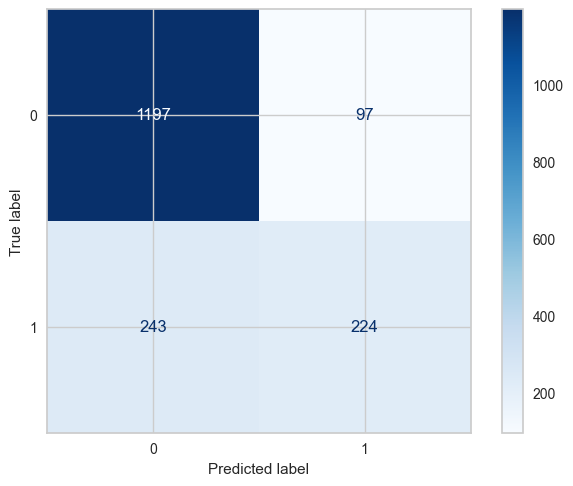

In [29]:
#First, get the predictions
predictions = best_model_raw.predict(x_test)

#Next, create the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=best_model_raw.classes_)

#Now display the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_raw.classes_)
disp.plot(cmap=plt.cm.Blues)
predictions

Now, let's look at a classification report.

In [30]:
print(classification_report(y_test, best_model_raw.predict(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1294
           1       0.70      0.48      0.57       467

    accuracy                           0.81      1761
   macro avg       0.76      0.70      0.72      1761
weighted avg       0.80      0.81      0.79      1761



Next, we'll perform the same steps with the standard scaled data.

In [31]:
features = df_standard_scaler.drop('Churn', axis=1)
targets = df_standard_scaler['Churn']
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

In [32]:
predictions = predict_model(best_model_standard_scaler, data=x_test)
predictions.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,prediction_label,prediction_score
customerID,,,,,,,,
8671-KKKOS,0.553872,-3.054010,-0.828207,1.145198,-0.638519,-0.097023,0,0.7397
6376-GAHQE,-1.158686,0.327438,-0.828207,1.145198,0.435002,-0.875329,1,0.6468
5446-DKWYW,1.165500,0.327438,0.371271,1.145198,0.014568,0.743069,0,0.9429
3978-YNKDD,-0.547058,0.327438,1.570749,-1.466165,-1.459446,-0.801028,0,0.9797
8532-UEFWH,0.798523,0.327438,1.570749,0.274744,-1.296590,-0.413255,0,0.9848
8541-QVFKM,-0.995585,0.327438,-0.828207,1.145198,0.290426,-0.728317,0,0.5539
0970-ETWGE,-1.281012,0.327438,-0.828207,1.145198,0.823863,-0.967886,1,0.8626
6711-VTNRE,0.146120,0.327438,-0.828207,1.145198,0.757391,0.351499,0,0.5249
4619-EVPHY,-0.506283,0.327438,0.371271,-0.595711,0.872055,-0.186489,0,0.8700


array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

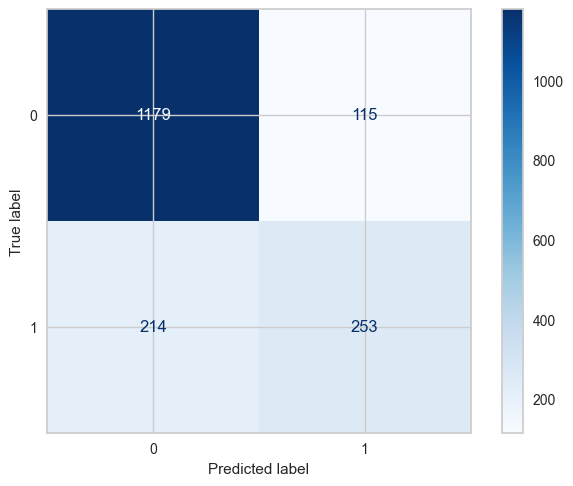

In [33]:
#First, get the predictions
predictions = best_model_standard_scaler.predict(x_test)

#Next, create the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=best_model_standard_scaler.classes_)

#Now display the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_standard_scaler.classes_)
disp.plot(cmap=plt.cm.Blues)
predictions

In [34]:
print(classification_report(y_test, best_model_standard_scaler.predict(x_test)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1294
           1       0.69      0.54      0.61       467

    accuracy                           0.81      1761
   macro avg       0.77      0.73      0.74      1761
weighted avg       0.80      0.81      0.81      1761



Finally, we'll repeat the same steps with the normalized data.

In [35]:
features = df_normalizer.drop('Churn', axis=1)
targets = df_normalizer['Churn']
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

In [36]:
predictions = predict_model(best_model_normalizer, data=x_test)
predictions.sample(10)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,prediction_label,prediction_score
customerID,,,,,,,,
8671-KKKOS,0.021329,0.000000,0.000000,0.001391,0.021120,0.956160,0,0.7374
6376-GAHQE,0.010388,0.002597,0.000000,0.007791,0.202182,0.777042,1,0.6344
5446-DKWYW,0.014892,0.000244,0.000244,0.000732,0.015917,0.967971,0,0.9610
3978-YNKDD,0.037229,0.001959,0.003919,0.000000,0.040854,0.916038,0,0.9771
8532-UEFWH,0.036399,0.000700,0.001400,0.001400,0.018025,0.942076,0,0.9784
8541-QVFKM,0.011147,0.001393,0.000000,0.004180,0.102410,0.880869,1,0.5229
0970-ETWGE,0.005432,0.005432,0.000000,0.016295,0.486420,0.486420,1,0.7276
6711-VTNRE,0.011230,0.000312,0.000000,0.000936,0.027311,0.960211,1,0.5455
4619-EVPHY,0.010134,0.000507,0.000507,0.000507,0.046111,0.942235,0,0.8404


array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

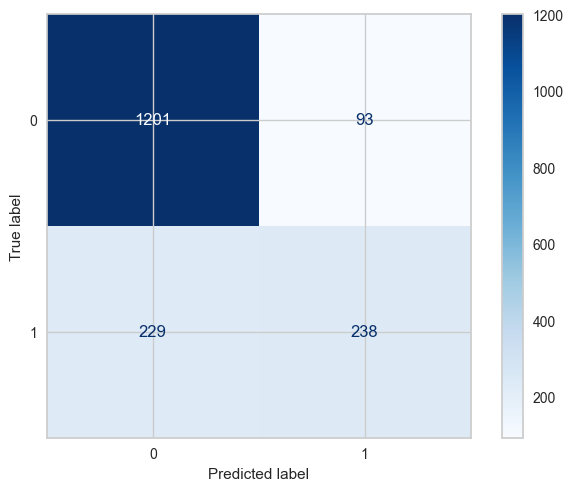

In [37]:
#First, get the predictions
predictions = best_model_normalizer.predict(x_test)

#Next, create the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=best_model_normalizer.classes_)

#Now display the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_normalizer.classes_)
disp.plot(cmap=plt.cm.Blues)
predictions

In [38]:
print(classification_report(y_test, best_model_normalizer.predict(x_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1294
           1       0.72      0.51      0.60       467

    accuracy                           0.82      1761
   macro avg       0.78      0.72      0.74      1761
weighted avg       0.81      0.82      0.81      1761



## Save the model to disk

In this case, we'll save all three models.

In [39]:
save_model(best_model_raw, 'Best_Model_Churn_Raw_Data')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'PhoneService',
                                              'Contract', 'PaymentMethod',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',...
                                             criterion='friedman_mse', init=None,
                      

In [40]:
save_model(best_model_standard_scaler, 'Best_Model_Churn_Standard_Scaler')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'PhoneService',
                                              'Contract', 'PaymentMethod',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',...
                                             criterion='friedman_mse', init=None,
                      

In [41]:
save_model(best_model_normalizer, 'Best_Model_Churn_Normalizer')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'PhoneService',
                                              'Contract', 'PaymentMethod',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',...
                                             criterion='friedman_mse', init=None,
                      

Let's examine the predictions.

## Create a Python script/file/module with a function that takes a pandas dataframe as an input and returns the probability of churn for each row in the dataframe

Your Python file/function should print out the predictions for new data (new_churn_data.csv)

In [42]:
Code('predict_churn.py')

import pandas as pd
import numpy as np
from pycaret.classification import predict_model, load_model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

model = load_model('Best_Model_Churn_Raw_Data')

def load_data(filepath):
    """
    Loads churn data into a DataFrame from a string filepath.
    """
    df = pd.read_csv(filepath, index_col='customerID')
    return df


def make_predictions(df, threshold=0.70):
    """
    Uses the pycaret best model to make predictions on data in the df dataframe.
    Rounds up to 1 if greater than or equal to the threshold.
    """
    predictions = predict_model(model, data=df)
    predictions['Churn_prediction'] = (predictions['prediction_score'] >= threshold)
    predictions['Churn_prediction'].replace({True: 'Churn', False: 'No Churn'}, inplace=True)
    drop_cols = predictions.columns.tolist()
    drop_cols.remove('Churn_prediction')
    return predictions.drop(drop_cols, axis=1)


if __name__ == "__main__":
    df = load_data('./data/new_churn_data.csv')
    #df_copy = df.copy()
    #df = df.drop('tenure', axis=1)
    if 'charge_per_tenure' in df.columns:
        df = df.drop('charge_per_tenure', axis=1)
    #df = df.drop('PhoneService', axis=1)
    #df = df.drop('Contract', axis=1)
    #df = df.drop('PaymentMethod', axis=1)
    #scaler = StandardScaler()
    #df_copy = df.copy()
    #df.iloc[:,:] = scaler.fit_transform(df)
    #scaled_data
    #df.iloc[:,:] = Normalizer(norm='l1').fit_transform(df)
    #df['Churn'] = df_copy['Churn']
    #df['tenure'] = df['tenure'] / df['tenure'].max()
    #df['MonthlyCharges'] = df['MonthlyCharges'] / df['MonthlyCharges'].max()
    #df['TotalCharges'] = df['TotalCharges'] / df['TotalCharges'].max()
    column_names = ['tenure', 'PhoneService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
    predictions = make_predictions(df)
    print('predictions:')
    print(predictions)

Test your Python module and function with the new data, new_churn_data.csv. The true values for the new data are [1, 0, 0, 1, 0] if you're interested.

In [43]:
%run predict_churn.py

Transformation Pipeline and Model Successfully Loaded


predictions:
           Churn_prediction
customerID                 
9305-CKSKC         No Churn
1452-KNGVK            Churn
6723-OKKJM            Churn
7832-POPKP            Churn
6348-TACGU            Churn


<Figure size 800x550 with 0 Axes>

In [44]:
Code('predict_churn_standard_scaler.py')

import pandas as pd
import numpy as np
from pycaret.classification import predict_model, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

model = load_model('Best_Model_Churn_Standard_Scaler')

def load_data(filepath):
    """
    Loads churn data into a DataFrame from a string filepath.
    """
    df = pd.read_csv(filepath, index_col='customerID')
    return df


def make_predictions(df, threshold=0.70):
    """
    Uses the pycaret best model to make predictions on data in the df dataframe.
    Rounds up to 1 if greater than or equal to the threshold.
    """
    predictions = predict_model(model, data=df)
    predictions['Churn_prediction'] = (predictions['prediction_score'] >= threshold)
    predictions['Churn_prediction'].replace({True: 'Churn', False: 'No Churn'}, inplace=True)
    drop_cols = predictions.columns.tolist()
    drop_cols.remove('Churn_prediction')
    return predictions.drop(drop_cols, axis=1)


if __name__ == "__main__":
    df = load_data('./data/new_churn_data.csv')
    #df_copy = df.copy()
    #df = df.drop('tenure', axis=1)
    if 'charge_per_tenure' in df.columns:
        df = df.drop('charge_per_tenure', axis=1)
    #df = df.drop('PhoneService', axis=1)
    #df = df.drop('Contract', axis=1)
    #df = df.drop('PaymentMethod', axis=1)
    scaler = StandardScaler()
    #df_copy = df.copy()
    df.iloc[:,:] = scaler.fit_transform(df)
    #scaled_data
    #df.iloc[:,:] = Normalizer(norm='l1').fit_transform(df)
    #df['Churn'] = df_copy['Churn']
    #df['tenure'] = df['tenure'] / df['tenure'].max()
    #df['MonthlyCharges'] = df['MonthlyCharges'] / df['MonthlyCharges'].max()
    #df['TotalCharges'] = df['TotalCharges'] / df['TotalCharges'].max()
    #column_names = ['tenure', 'MonthlyCharges', 'TotalCharges']
    column_names = ['tenure', 'PhoneService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
    predictions = make_predictions(df)
    print('predictions:')
    print(predictions)

In [45]:
%run predict_churn_standard_scaler.py

Transformation Pipeline and Model Successfully Loaded


predictions:
           Churn_prediction
customerID                 
9305-CKSKC         No Churn
1452-KNGVK            Churn
6723-OKKJM            Churn
7832-POPKP            Churn
6348-TACGU         No Churn


In [46]:
Code('predict_churn_normalizer.py')

import pandas as pd
import numpy as np
from pycaret.classification import predict_model, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

model = load_model('Best_Model_Churn_Normalizer')

def load_data(filepath):
    """
    Loads churn data into a DataFrame from a string filepath.
    """
    df = pd.read_csv(filepath, index_col='customerID')
    return df


def make_predictions(df, threshold=0.70):
    """
    Uses the pycaret best model to make predictions on data in the df dataframe.
    Rounds up to 1 if greater than or equal to the threshold.
    """
    predictions = predict_model(model, data=df)
    predictions['Churn_prediction'] = (predictions['prediction_score'] >= threshold)
    predictions['Churn_prediction'].replace({True: 'Churn', False: 'No Churn'}, inplace=True)
    drop_cols = predictions.columns.tolist()
    drop_cols.remove('Churn_prediction')
    return predictions.drop(drop_cols, axis=1)


if __name__ == "__main__":
    df = load_data('./data/new_churn_data.csv')
    #df_copy = df.copy()
    #df = df.drop('tenure', axis=1)
    if 'charge_per_tenure' in df.columns:
        df = df.drop('charge_per_tenure', axis=1)
    #df = df.drop('PhoneService', axis=1)
    #df = df.drop('Contract', axis=1)
    #df = df.drop('PaymentMethod', axis=1)
    #scaler = StandardScaler()
    #df_copy = df.copy()
    #df.iloc[:,:] = scaler.fit_transform(df)
    #scaled_data
    df.iloc[:,:] = Normalizer(norm='l1').fit_transform(df)
    #df['Churn'] = df_copy['Churn']
    #df['tenure'] = df['tenure'] / df['tenure'].max()
    #df['MonthlyCharges'] = df['MonthlyCharges'] / df['MonthlyCharges'].max()
    #df['TotalCharges'] = df['TotalCharges'] / df['TotalCharges'].max()
    #column_names = ['tenure', 'MonthlyCharges', 'TotalCharges']
    column_names = ['tenure', 'PhoneService', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
    predictions = make_predictions(df)
    print('predictions:')
    print(predictions)

In [47]:
%run predict_churn_normalizer.py

Transformation Pipeline and Model Successfully Loaded


predictions:
           Churn_prediction
customerID                 
9305-CKSKC            Churn
1452-KNGVK            Churn
6723-OKKJM            Churn
7832-POPKP            Churn
6348-TACGU            Churn


## Write a short summary of the process and results at the end of this notebook.

After installing and importing the necessary packages, I loaded the prepared churn data. I inspected the data to make sure all the columns were numeric, and there were no missing values. I then normalized the data using a standard scaler and a normalizer to see if we can get any better results. I then used pycaret to find the best model to train the dataset on for each dataset: the raw data, standard scale data and normalized data. I chose to search on the model with the best AUC score for each model. I then created our features and targets, then split the data into training and test sets, then plotted a confusion matrix to see how well the chosen model performed, especially for true positives. The TPR wasn’t great, in general, for all three models. We also displayed a classification report. The model is very good at predicting true negatives, but not so good at predicting true positives. I then saved all three models to disk, and printed out the prediction scores. I then created a Python script to evaluate the results of each model on new data it hasn’t seen yet. I then ran each Python script, on a hugher threshold of 70%. We then compared those results with the expected results, and the results wrre mixed. The results seemed to change slightly every time the notebook was executed from scratch. The dataset would likely need to be expanded to assess the true churn rate. Finally, I created a GitHub repository and put the three Python script files for analyzing the test set into that repository.